# Predicting Trading Volumes
How well do various model types do at predicting transaction volumes for equities?  Let's start by loading & parsing our dataset.  DB record their data as 1 csv per hour, 1 folder per day, so we write our ingestion code accordingly to load a day at once.

In [2]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import glob

%matplotlib inline


data_folder = "data/deutsche-boerse-xetra-pds/2018-06-21/"

def load_ts(full_path):
    df = pd.read_csv(full_path) 
    df["date-time"] = df[['Date', 'Time']].apply(lambda x: ' '.join(x), axis=1)
    df["date-time"] = pd.to_datetime(df["date-time"])
    df.set_index('date-time', inplace=True)
    return (df)


def load_day(target_path):
    dirlist = glob.glob(target_path + "*.csv")
    frames = []
    for path in dirlist:
        print("Loading " + path)
        frames.append(load_ts(path))

    return (pd.concat(frames))

df_train = load_day(data_folder)
print("Loaded " + str(df_train.shape[0]) + " rows")
df_train.head()

Loading data/deutsche-boerse-xetra-pds/2018-06-21\2018-06-21_BINS_XETR07.csv
Loading data/deutsche-boerse-xetra-pds/2018-06-21\2018-06-21_BINS_XETR08.csv
Loading data/deutsche-boerse-xetra-pds/2018-06-21\2018-06-21_BINS_XETR09.csv
Loading data/deutsche-boerse-xetra-pds/2018-06-21\2018-06-21_BINS_XETR10.csv
Loading data/deutsche-boerse-xetra-pds/2018-06-21\2018-06-21_BINS_XETR11.csv
Loading data/deutsche-boerse-xetra-pds/2018-06-21\2018-06-21_BINS_XETR12.csv
Loading data/deutsche-boerse-xetra-pds/2018-06-21\2018-06-21_BINS_XETR13.csv
Loading data/deutsche-boerse-xetra-pds/2018-06-21\2018-06-21_BINS_XETR14.csv
Loading data/deutsche-boerse-xetra-pds/2018-06-21\2018-06-21_BINS_XETR15.csv
Loaded 65915 rows


,ISIN,Mnemonic,SecurityDesc,SecurityType,Currency,SecurityID,Date,Time,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades
date-time,,,,,,,,,,,,,,
2018-06-21 07:00:00,AT0000A0E9W5,SANT,S+T AG (Z.REG.MK.Z.)O.N.,Common stock,EUR,2504159,2018-06-21,07:00,22.100,22.100,22.08,22.100,462,3
2018-06-21 07:00:00,DE000A0WMPJ6,AIXA,AIXTRON SE NA O.N.,Common stock,EUR,2504428,2018-06-21,07:00,11.915,11.935,11.91,11.915,4150,6
2018-06-21 07:00:00,DE000A0Z2XN6,RIB,RIB SOFTWARE SE NA EO 1,Common stock,EUR,2504436,2018-06-21,07:00,19.400,19.460,19.40,19.430,1317,5
2018-06-21 07:00:00,DE000A0Z2ZZ5,FNTN,FREENET AG NA O.N.,Common stock,EUR,2504438,2018-06-21,07:00,23.570,23.590,23.57,23.590,112,2
2018-06-21 07:00:00,DE000A1EWWW0,ADS,ADIDAS AG NA O.N.,Common stock,EUR,2504471,2018-06-21,07:00,189.150,189.700,189.05,189.700,1787,30


Let's find a popular security to do predictions on...

In [49]:
popular = df_train.groupby(by=["Mnemonic"])["TradedVolume"].count()
popular.sort_values(ascending=False).head(n=20)

Mnemonic
BAS     510
SIE     507
BMW     507
DBK     507
BAYN    507
1COV    507
VOW3    507
DAI     506
ALV     506
SAP     506
CBK     505
EOAN    505
DPW     501
ADS     498
MUV2    493
FRE     491
IFX     491
BEI     489
WDI     488
RWE     487
Name: TradedVolume, dtype: int64

All of the "top 10" equities are traded very frequently througout the day.  Let's plot trade volume for BASF.

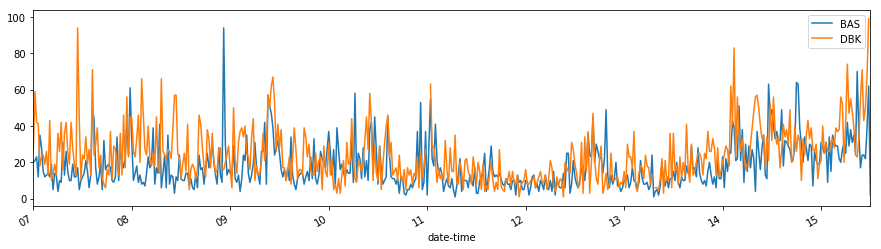

In [5]:
def plot_ts(my_ts, start_time = None, end_time = None):
    # Please specify dates as yyyy-mm-dd
    ax = my_ts.plot(figsize=(15,4))

    
    if (start_time is not None and end_time is not None):
        ax.set_xlim(pd.to_datetime(start_time), pd.to_datetime(end_time))
    
    ax.xaxis.set_major_locator(matplotlib.dates.HourLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H'))

    plt.show()
    return (plt)

trade_vols = {"DBK":df_train[df_train.Mnemonic == "DBK"]["NumberOfTrades"], "BAS":df_train[df_train.Mnemonic == "BAS"]["NumberOfTrades"]}
x = plot_ts(pd.DataFrame(trade_vols))

What about over shorter periods?

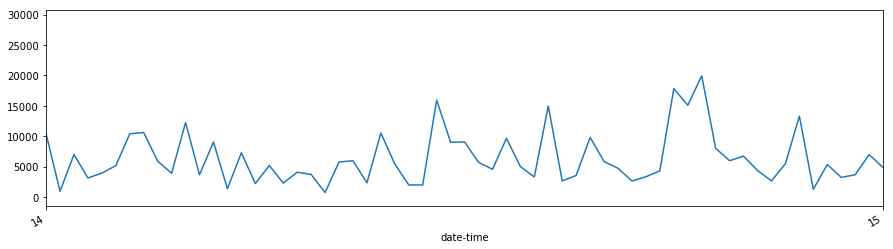

<module 'matplotlib.pyplot' from 'C:\\Users\\edwarddi\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [6]:
plot_ts(df_train[df_train.Mnemonic == "BAS"]["TradedVolume"], start_time = "2018-06-21 14:00", end_time = "2018-06-21 15:00")

We'll next resample the signal: even intervals are easier to work with, and with luck the smoothing will remove more noise than signal.  Pandas makes this so easy!  Rule of thumb: if it takes you more a than a few lines to do some dataframe manipulation, most likely there is a Pandas function that you should be using instead.

C:\Users\edwarddi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  This is separate from the ipykernel package so we can avoid doing imports until


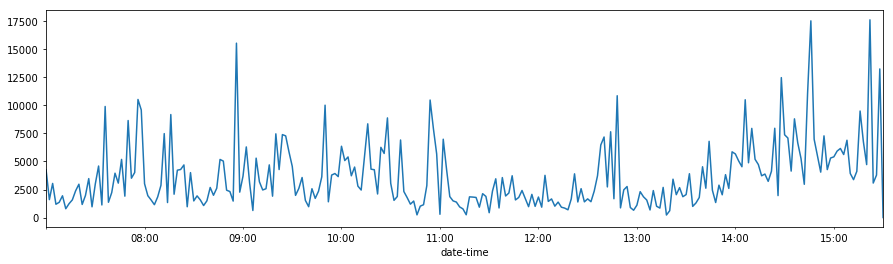

Data has 256 rows


C:\Users\edwarddi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
.resample() is now a deferred operation
You called shape(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  after removing the cwd from sys.path.


In [19]:
interval = '2Min'
smooth_bas = df_train[df_train.Mnemonic == "BAS"]["TradedVolume"].resample(interval)
plot_ts(smooth_bas)
print("Data has " + str(smooth_bas.shape[0]) + " rows")

## Preparing for Machine Learning
Now that we've learned to turn our irregular training data into a tidy little signal sampled at regular intervals, we can turn it into a matrix of inputs X and target values Y.  We'll pick Y to be a few time intervals into the future; the idea here is that we want enough warning of heavy traffic to be able to spin up more VMs to meet it.

As well as creating our orderly X (one little timeseries per row), we will also want to normalize our data.  This is a key step because some of the machine learning model types we want to try will work much better if the data has a mean of about zero and most values in the range -1 to +1.

In [52]:
import numpy as np


def normalize_mat(mat):
    # Given a numpy matrix, does row-wise normalization
    
    norm_mat = mat - mat.mean(axis=1).reshape(mat.shape[0],1)
    norm_mat = norm_mat / norm_mat.std(axis=1).reshape(norm_mat.shape[0],1)
        
    return (norm_mat)


def to_supervised(df_ts, num_points = 10, look_ahead = 5):
    # Turns a series into a matrix!
    # We'll use the Pandas .shift function to create a matrix with a mini-timeseries per row
    df_result = pd.DataFrame()
    for i in range(0, num_points):        
        # Move back one more timestep on each loop
        X_col = df_ts.shift(i)        
        X_colname = "X_" + str(i)
        
        df_result[X_colname] = X_col        
        
    
    Y = df_ts.shift(num_points + look_ahead - 1)
    df_result['Y'] = Y
    
    # Shifting each column has resulted in some missing values - need to get rid of those
    mat_ts = df_result.dropna().values
    
    # Let's normalize our data.  Some model types - especially neural networks - really require this
    mat_ts = normalize_mat(mat_ts)
    
    # Now that they've been normalized along with the "predictor" values, we can separate out our target/label values
    Y = mat_ts[:,mat_ts.shape[1] - 1]
    
    return(mat_ts[:,:mat_ts.shape[1] - 1], Y)
    
    
ts_mat, Y = to_supervised(smooth_bas)
print(ts_mat[0:5,])
print(Y[0:5])
print("Dataset of " + str(Y.shape[0]) + " samples ready for training")

[[-1.04575694  1.32805798 -0.09093165 -0.84703216  0.85537688  0.29989377
  -0.46330405 -0.78362948 -1.20662939 -0.11884775]
 [ 1.23802855 -1.10325688  1.78066873  0.05675147 -0.86182799  1.20641286
   0.53156162 -0.39564029 -0.78480067 -1.29869932]
 [ 2.02964046  0.55680439 -1.33022339  0.99416119 -0.39528058 -1.13563668
   0.5313228  -0.01259338 -0.75989901 -1.07355425]
 [-0.9757997   2.11639859  0.69627459 -1.12321741  1.1179786  -0.22173574
  -0.93559486  0.67170497  0.14725527 -0.57330466]
 [ 2.83042437 -0.76493517  0.65612797  0.00349004 -0.83268305  0.19729004
  -0.41839449 -0.74645848 -0.00780127 -0.24881949]]
[ 2.07280279 -0.36919808  0.59525843 -0.91995965 -0.66824047]
Dataset of 242 samples ready for training


C:\Users\edwarddi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: 
.resample() is now a deferred operation
You called shift(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
C:\Users\edwarddi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: 
.resample() is now a deferred operation
You called shift(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead


In [42]:
a = smooth_bas.values
a[0:10]

C:\Users\edwarddi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.resample() is now a deferred operation
You called values(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  """Entry point for launching an IPython kernel.


array([ 4259.5,  1602.5,  3042. ,  1191.5,  1364.5,  1943.5,   794. ,
        1241. ,  1579.5,  2386. ])